In [1]:
# 
# Use pretrained PyTorch models
#
# https://www.kaggle.com/c/dog-breed-identification/overview
# https://www.kaggle.com/pvlima/pretrained-pytorch-models
#

from __future__ import print_function, division

import copy
import numpy as np
import pandas as pd
from os import listdir
from os.path import join
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, datasets, models

print(torch.__version__)
print(torchvision.__version__)

1.5.1
0.6.1


In [2]:
RawPath = r'D:\GitWork\dog_breed\data\raw'
print("Raw path: '{}'".format(RawPath))

ModelPath = r'D:\GitWork\dog_breed\models'
print("Model path: '{}'".format(ModelPath))

Raw path: 'D:\GitWork\dog_breed\data\raw'
Model path: 'D:\GitWork\dog_breed\models'


In [3]:
INPUT_SIZE = 224
NUM_CLASSES = 16

data_dir = RawPath
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [4]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
print(labels.head())

labels['target'] = 1
print(); print(labels.head())

# labels['rank'] = labels.groupby('breed').rank()['id']
labels['rank'] = labels.groupby('breed').rank()
print(); print(labels.head())

labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
print(); print(labels_pivot)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(); print(train.shape, valid.shape)

                                  id               breed
8   003df8b8a8b05244b1d920bb6cf451f9             basenji
9   0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound
12  00693b8bc2470375cc744a6391d397ec         maltese_dog
29  00bee065dcec471f26394855c5c2f3de               cairn
48  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier

                                  id               breed  target
8   003df8b8a8b05244b1d920bb6cf451f9             basenji       1
9   0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound       1
12  00693b8bc2470375cc744a6391d397ec         maltese_dog       1
29  00bee065dcec471f26394855c5c2f3de               cairn       1
48  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier       1

                                  id               breed  target  rank
8   003df8b8a8b05244b1d920bb6cf451f9             basenji       1  55.5
9   0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound       1  63.5
12  00693b8bc2470375cc744a6391d397ec         maltese_

In [5]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]
    
normalize = transforms.Normalize(
   mean = [0.485, 0.456, 0.406],
   std  = [0.229, 0.224, 0.225]
)

ds_trans = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

train_imgpath = join(data_dir,'train')
train_ds = DogsDataset(train, train_imgpath, transform=ds_trans)
valid_ds = DogsDataset(valid, train_imgpath, transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True)    

In [6]:
imgs, lbls = next(iter(train_dl))

print('\nImage type: ', type(imgs))
print('      size: ', imgs.size())

print('\nLabel type: ', type(lbls))
print('      size: ', lbls.size())

img = imgs[0]
print('\nImage shape:', img.shape)
print(); print(img)

lbl = lbls[0]
print('\nLabel shape:', lbl)
print(); print(lbl)


Image type:  <class 'torch.Tensor'>
      size:  torch.Size([4, 3, 224, 224])

Label type:  <class 'torch.Tensor'>
      size:  torch.Size([4])

Image shape: torch.Size([3, 224, 224])

tensor([[[-0.5082, -0.5424, -0.5596,  ...,  0.5364,  0.3823,  0.2967],
         [-0.5596, -0.5253, -0.4911,  ...,  0.4337,  0.0056,  0.0398],
         [-0.4911, -0.4568, -0.4739,  ...,  0.0227,  0.5193,  1.2557],
         ...,
         [ 2.2489,  2.2489,  2.2489,  ...,  0.6734,  0.6906,  0.5364],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.7419,  0.8618,  0.7591],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.8447,  0.7762,  0.7762]],

        [[-1.1604, -1.1954, -1.2129,  ..., -0.9503, -0.8978, -0.9153],
         [-1.2129, -1.1779, -1.1429,  ..., -0.9678, -1.0028, -0.8627],
         [-1.1604, -1.1253, -1.1429,  ..., -0.7577,  0.5903,  1.5532],
         ...,
         [ 2.4286,  2.4286,  2.4286,  ...,  1.0280,  1.0105,  0.8529],
         [ 2.4286,  2.4286,  2.4286,  ...,  1.1331,  1.2031,  1.0805],
   

torch.Size([4, 3, 224, 224]) torch.Size([4])


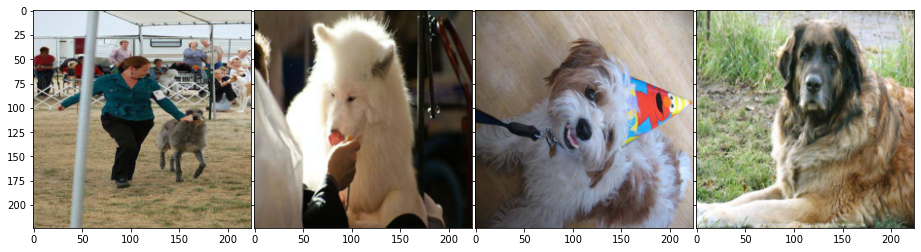

In [7]:
import matplotlib.pyplot as plt

def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    # maxValue = np.amax(inp)
    # minValue = np.amin(inp)
    # print(maxValue, minValue)
    
    # All values were in between (0, 1.0000000236034394), 
    # so simply clipped the data
    inp = np.clip(inp, 0, 1)
    axis.imshow(inp)
    
    
img, label = next(iter(train_dl))
print(img.size(), label.size())

fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [8]:
from torch.autograd import Variable

use_gpu = torch.cuda.is_available()

resnet = models.resnet50(pretrained=True)

# Load pretrained model
pre_model_path = join(ModelPath, 'resnet50-19c8e357.pth')
pre_model_wts = torch.load(pre_model_path)
resnet.load_state_dict(pre_model_wts)

inputs, labels = next(iter(train_dl))

if use_gpu:
    resnet = resnet.cuda()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
else:
    inputs, labels = Variable(inputs), Variable(labels)
    
outputs = resnet(inputs)
print(outputs.size())

torch.Size([4, 1000])


In [9]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    use_gpu = torch.cuda.is_available()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        
        for phase in ['train', 'valid']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistic
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()                
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc  = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc  = running_corrects.double() / dataset_sizes[phase]

            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                  epoch, num_epochs - 1,
                  train_epoch_loss, train_epoch_acc, 
                  valid_epoch_loss, valid_epoch_acc))

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model                   

In [10]:
from torch.optim import lr_scheduler

resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 16 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 16)
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [11]:
import time

start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/1] train loss: 0.3809 acc: 0.5584 valid loss: 0.0802 acc: 0.9239
Epoch [1/1] train loss: 0.1823 acc: 0.8010 valid loss: 0.0550 acc: 0.9380
Best val Acc: 0.938028
Training time:   1.007988 minutes


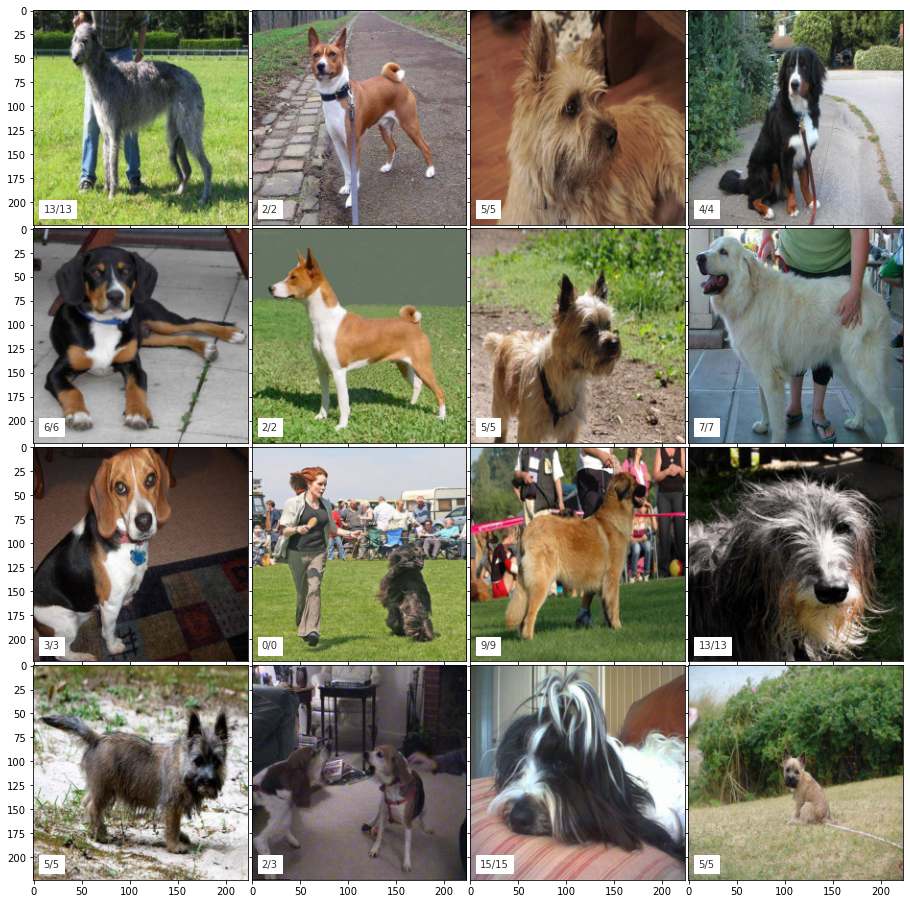

In [12]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:                
                return

visualize_model(dloaders, resnet)            